# Numerical Solvers

### Matthew Kafker, Jeremy Welsh-Kavan

<hr>

The goal of this project is to build a program for numerically solving various ODEs and PDEs. By validating various numerical methods on DEs with known analytical solutions, we hope to be able to implement these methods for a much larger set DEs.

We start with a naive approach and propagate our solution in time using information from the spatial derivative. This is analogous to the the initial value problem (IVP) in which we hope to solve for $y(t)$ given

$
y'(t) = f(t, y(t)) ~~~~~ y(t_0) = y_0
$

Instead, we are solving for $u(x,t)$ given

$
\partial_t u(x,t) = \partial_{xx} u(x,t) \\
u(x,0) = f(x) \\
u(0,t) = u(L,t) = 0 \\
$

for $x \in [0,L]$ and $t>0$.



[//]: <> (For instructions on how to use LaTeX, see the LaTeX folder, which also contains a few other TeXShop files.)

<hr>

Most of what we implement here will be informed by the following resources:

Asmar, Nakhlé H., and Nakhlé H. Asmar. Partial Differential Equations with Fourier Series and Boundary Value Problems. 2nd ed. Upper Saddle River, N. j: Pearson Prentice Hall, 2005. Print.

Press, William H. Numerical Recipes : the Art of Scientific Computing. Cambridge ;: Cambridge University Press, 1989. Print.

Kutz, Jose Nathan. Data-Driven Modeling & Scientific Computation : Methods for Complex Systems & Big Data. First edition. Oxford: Oxford University Press, 2013. Print.

Libraries and plotting preferences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.figsize'] = [8, 6]

## Simulation Set-Up

Define grid in position and momentum$\leftrightarrow$wave vector.

In [2]:
L = 10
xmin, xmax = 0, L
res = 1024
x_arr = np.linspace(xmin, xmax, res)
dx = (x_arr[1]-x_arr[0])
N = len(x_arr)

kmax = np.pi/dx
kmin = 2*np.pi/L
k_pos = np.arange(0, kmax, kmin)
k_neg = np.arange(-kmax, 0, kmin)
k_arr = np.concatenate([k_pos, k_neg])

In [8]:
dx

0.009775171065493646

Define mass distribution.

In [3]:
sig = L/40
f_arr = (2*np.pi*sig**2)**(-0.5)*np.exp(-((x_arr-L/2)**2.0)/(2*sig**2))

In [4]:
f_deriv_anly = (2*np.pi*sig**2)**(-0.5)*(((x_arr-L/2)**2/sig**4)*np.exp(-((x_arr-L/2)**2.0)/(2*sig**2)) -(1/sig**2)*np.exp(-((x_arr-L/2)**2.0)/(2*sig**2)))

Check normalization of mass distribution.

In [5]:
(f_arr*dx).sum()

1.0000000000000007

Plot mass distribution.

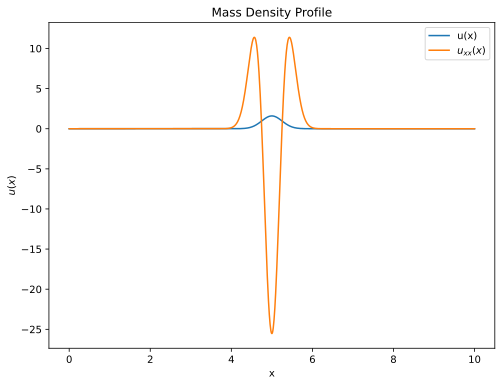

In [6]:
plt.plot(x_arr, f_arr,label="u(x)")
plt.plot(x_arr, f_deriv_anly,label=r"$u_{xx}(x)$")
plt.xlabel("x")
plt.ylabel("$u(x)$")
plt.title("Mass Density Profile")
plt.legend()
plt.show()

Perform spatial derivatives of mass distribution using FFT.

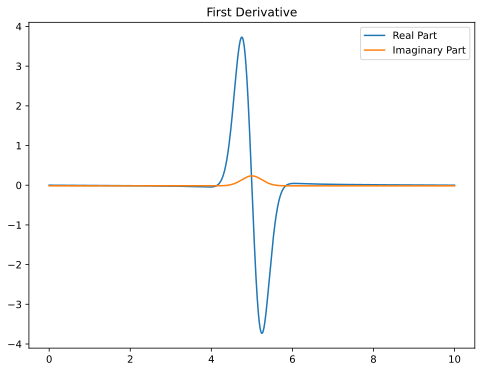

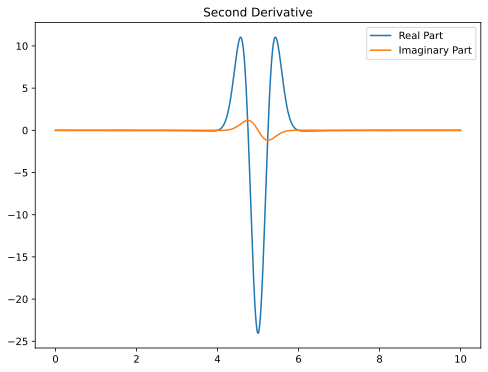

In [7]:
f_arr_fft = np.fft.fft(f_arr) 
deriv_f_arr = np.fft.ifft(1j*k_arr*f_arr_fft)

plt.plot(x_arr, np.real(deriv_f_arr),label="Real Part")
plt.plot(x_arr, np.imag(deriv_f_arr),label="Imaginary Part")
plt.title("First Derivative")
plt.legend()
plt.show()

deriv_f_arr_2 = np.fft.ifft(-(k_arr**2)*f_arr_fft)
plt.plot(x_arr, np.real(deriv_f_arr_2),label="Real Part")
plt.plot(x_arr, np.imag(deriv_f_arr_2),label="Imaginary Part")
plt.title("Second Derivative")
plt.legend()
plt.show()

## Time-Stepping

We wish to solve the diffusion equation, $u_t=D u_{xx}$ in our simulation box for some interval of time.

Function to evaluate RHS.

In [11]:
def deriv(u,D):
    return D*np.fft.ifft(-(k_arr**2)*np.fft.fft(u))

### Solver 1: Forward Euler

The Forward Euler technique implements the time-stepping scheme $$u(x,t+dt) = u(x,t) + D u_{xx}(x,t)dt$$

Time-stepper parameters and initial conditions:

In [132]:
dt_FE = 0.001
T_FE = 100
s_FE = int(np.ceil(T_FE/dt_FE))
u_FE = np.zeros([s_FE,len(x_arr)],dtype = 'complex_') # Fixes "ComplexWarning: Casting complex values to real discards the imaginary part"
u_FE[0] = f_arr
D_FE = 0.01

Perform numerical integration

In [133]:
for t in range(0,s_FE-1):
    u_FE[t+1] = u_FE[t]+dt_FE*deriv(u_FE[t],D_FE)
    
# NOTE: somewhere we appear to be throwing out complex part. Shouldn't do that!

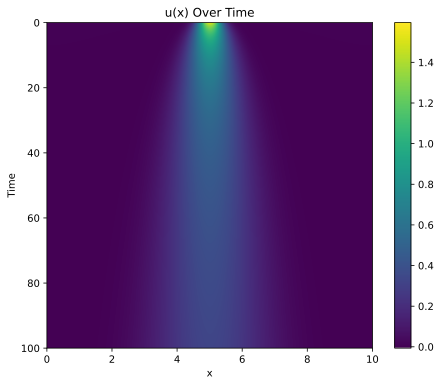

In [137]:
plt.imshow(np.real(u_FE),aspect="0.1",extent=[0,L,T_FE,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

Test mass conservation

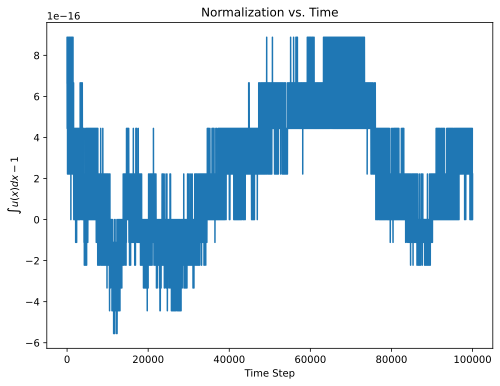

In [138]:
norm = np.array([(u_FE[t]*dx).sum() for t in range(s_FE)], dtype="complex_")
plt.plot(np.real(norm) - 1)
plt.xlabel("Time Step")
plt.ylabel("$\int u(x)dx -1$")
plt.title("Normalization vs. Time")
plt.show()

In [139]:
np.max(np.imag(norm))

2.42861286636753e-17

### Solver 2: Runge-Kutta 4

In [140]:
dt_RK4 = 0.001
T_RK4 = 100
s_RK4 = int(np.ceil(T_RK4/dt_RK4))
u_RK4 = np.zeros([s_RK4,len(x_arr)],dtype="complex_")
D_RK4 = 0.01
# Need 4 initial values now
u_RK4[0]=f_arr

In [141]:
for t in range(0,s_RK4-1):
    f1 = deriv(u_RK4[t],D_RK4)
    f2 = deriv(u_RK4[t] + (dt_RK4/2)*f1,D_RK4)
    f3 = deriv(u_RK4[t] + (dt_RK4/2)*f2,D_RK4)
    f4 = deriv(u_RK4[t] + dt_RK4*f3,D_RK4)
    u_RK4[t+1] = u_RK4[t] + (dt_RK4/6)*(f1 + 2*f2 + 2*f3 + f4)

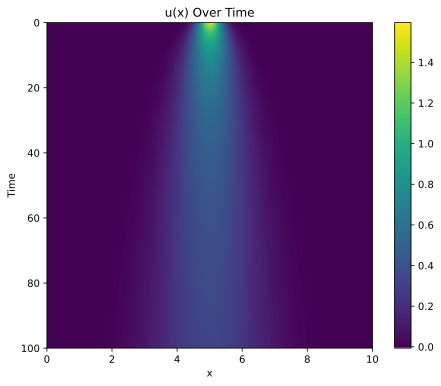

In [142]:
plt.imshow(np.real(u_RK4),aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

$\textbf{Analysis}$

We still cannot make the diffusion constant arbitrarily large. $D \approx 0.02$ appears to be close to the upper bound where the solver does not crash. Perhaps this has something to do with the the density becoming non-negligible at the boundary?

Also, even with 4th order Runge-Kutta, with truncation error of order $\Delta t ^5$, we still cannot significantly increase $dt > 0.001$ without the solver failing. Why?

### Fourier Series solution


In [143]:
M = 120
n_arr = np.arange(1,M+1)
lambda_n = np.sqrt(D_RK4)*n_arr*np.pi/L
xn_arr = n_arr[:,np.newaxis]@x_arr[np.newaxis]
t_arr  = np.arange(0, T_RK4, dt_RK4)
sin_arr = np.sin(np.pi*xn_arr/L)
b_n = (2/L)*np.array([np.trapz(f_arr*line,dx=dx) for line in sin_arr])
exp_arr = np.exp(-(lambda_n**2)[:,np.newaxis]@t_arr[np.newaxis])

In [144]:
u_ANLY = ((b_n*exp_arr.T)@sin_arr)
u_ANLY.shape

(100000, 1024)

Comparing Fourier Series IC with exact.

In [145]:
np.max(np.abs(u_ANLY[0] - f_arr))/np.max(f_arr)

2.9110710469221243e-15

Although the Fourier series is accurate at short times, it eventually deviates from the infinite-space solution, which we can see by monitoring its normalization vs. time.

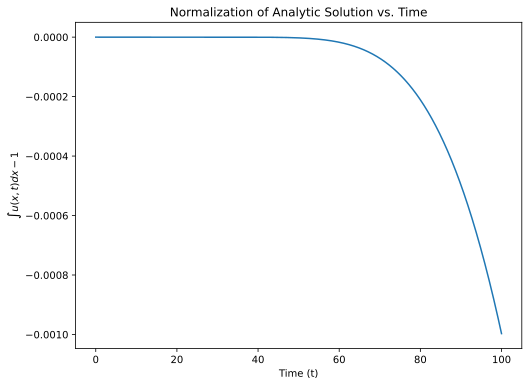

In [146]:
plt.plot(t_arr,[-1+(u_ANLY[j].sum())*dx for j in range(len(u_ANLY))])
plt.xlabel("Time (t)")
plt.ylabel("$\int u(x,t)dx -1$")
plt.title("Normalization of Analytic Solution vs. Time")
plt.show()

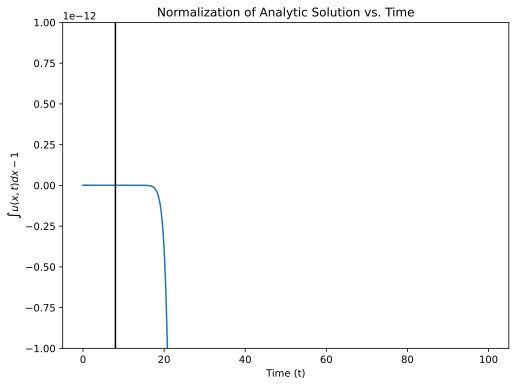

In [147]:
plt.plot(t_arr,[-1+(u_ANLY[j].sum())*dx for j in range(len(u_ANLY))])
plt.xlabel("Time (t)")
plt.ylabel("$\int u(x,t)dx -1$")
plt.title("Normalization of Analytic Solution vs. Time")
plt.vlines(8,-1e-12,1e-12,"k")
plt.ylim([-1e-12,1e-12])
plt.show()

In [148]:
t_arr[8000]

8.0

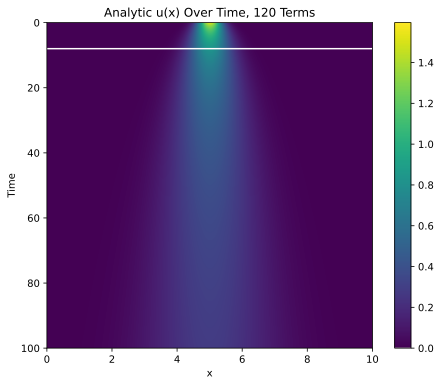

In [149]:
plt.imshow(u_ANLY,aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title(f"Analytic u(x) Over Time, {M} Terms")
plt.colorbar()
plt.hlines(8,0,L,"w")
plt.show()

Comparing analytical with numerical results, keeping in mind that we know the analytical results are not trustworthy beyond ~ t = 8.

In [150]:
np.max(np.abs(u_ANLY - u_RK4))/np.max(u_ANLY)

0.02990535328456535

In [151]:
np.max(np.abs(u_RK4 - u_FE))/np.max(u_RK4)

(2.097204790197692e-05+0j)

In [152]:
np.max(np.abs(u_ANLY[0:8000] - u_RK4[0:8000]))/np.max(u_ANLY[0:8000])

0.02155623452922159

In [153]:
np.max(np.abs(u_ANLY[0:8000] - u_FE[0:8000]))/np.max(u_ANLY[0:8000])

0.021543943150587143

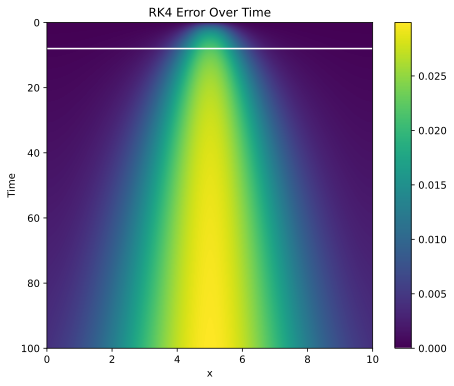

In [154]:
plt.imshow(np.abs(u_ANLY - u_RK4)/np.max(u_ANLY),aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("RK4 Error Over Time")
plt.colorbar()
plt.hlines(8,0,L,"w")
plt.show()

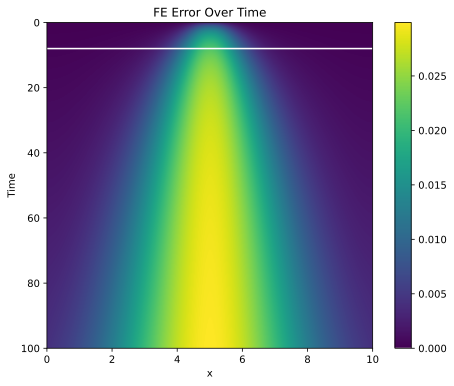

In [155]:
plt.imshow(np.abs(u_ANLY - u_FE)/np.max(u_ANLY),aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("FE Error Over Time")
plt.colorbar()
plt.hlines(8,0,L,"w")
plt.show()

### Attempt 4: Using replacing derivative with matrix from PHYSICAL REVIEW C 87, 051301(R) (2013)

This essentially comes from unwrapping the FFT second derivative.

$$\Bigl(\frac{d^2}{dx^2}\Bigr)_{i,j}= \begin{cases}-\frac{2 \pi^2}{N^2 dx^2} \frac{(-1)^{i-j}}{\text{sin}^2(\frac{\pi (i-j)}{N})} \\ -\frac{\pi^2}{3 dx^2}(1+\frac{2}{N^2}) \end{cases}$$

Defining the derivative matrix.

In [156]:
derivmat = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        if i!=j:
            derivmat[i,j] = -( 2*(np.pi**2)/(N**2 * dx**2) ) * (-1)**(i-j)/np.sin(np.pi*(i-j)/N)**2
        else:
            derivmat[i,j] = -( (np.pi**2)/(3 * dx**2) ) * (1 + 2/N**2)

Comparing second derivative with that due to FFT.

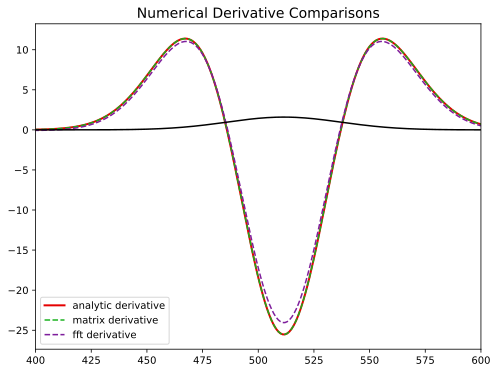

Mean Squared Error
fft derivative error: 0.07681687102742213
matrix derivative error: 2.7690104357280847e-23
Max Absolute Error
fft derivative error: 0.05776177553843428
matrix derivative error: 2.5443483862777175e-12


In [157]:
plt.plot(f_deriv_anly, linewidth=2.0, c="xkcd:red" ,label="analytic derivative")
plt.plot(derivmat@f_arr, '--',c="xkcd:green" , label="matrix derivative")
plt.plot(np.real(deriv_f_arr_2),'--',c="xkcd:purple" ,label="fft derivative")
plt.plot(f_arr, c="xkcd:black")
plt.xlim((400,600))
plt.legend()
plt.title("Numerical Derivative Comparisons",size=14)
plt.show()

fft_mse_err = ((np.real(deriv_f_arr_2) - f_deriv_anly)**2).mean()
mat_mse_err = ((derivmat@f_arr - f_deriv_anly)**2).mean()
print(f"Mean Squared Error")
print(f"fft derivative error: {fft_mse_err}")
print(f"matrix derivative error: {mat_mse_err}")


fft_mae_err = np.max(np.abs(np.real(deriv_f_arr_2) - f_deriv_anly))/np.max(np.abs(f_deriv_anly))
mat_mae_err = np.max(np.abs(derivmat@f_arr - f_deriv_anly))/np.max(np.abs(f_deriv_anly))
print(f"Max Absolute Error")
print(f"fft derivative error: {fft_mae_err}")
print(f"matrix derivative error: {mat_mae_err}")

This definitely suggests that the matrix derivative will be a better choice. Nice.

In [158]:
# Compile with jit for faster matmul. WARNING: Jit is extremely temperamental
from numba import jit
@jit(nopython=True)
def deriv2(u,D):
    global derivmat
    return D*derivmat@u

In [159]:
np.max(np.abs(deriv2(f_arr,D_RK4)-deriv(f_arr,D_RK4)))/np.max(np.abs(deriv(f_arr,D_RK4)))

0.061323033167564295

In [160]:
%time deriv2(f_arr,D_RK4)

CPU times: user 10.2 ms, sys: 225 µs, total: 10.4 ms
Wall time: 1.36 ms


array([-6.93889390e-18, -2.77555756e-17, -1.38777878e-17, ...,
       -2.77555756e-17, -4.16333634e-17, -4.16333634e-17])

In [161]:
%time D_RK4*derivmat@f_arr

CPU times: user 32 ms, sys: 3.83 ms, total: 35.9 ms
Wall time: 4.37 ms


array([-6.93889390e-18, -2.77555756e-17, -1.38777878e-17, ...,
       -2.77555756e-17, -4.16333634e-17, -4.16333634e-17])

#### RK4 again, but with matrix 2nd derivative

This is computationally very expensive, requiring 4 matrix multiplications per time step, where the matrix is $N \times N$

In [185]:
dt_RK4_2 = 0.001
T_RK4_2 = 100
s_RK4_2 = int(np.ceil(T_RK4_2/dt_RK4_2))
u_RK4_2 = np.zeros([s_RK4_2,N])
D_RK4_2 = 0.01
# Need 4 initial values now
u_RK4_2[0]=f_arr

Time evolution is now $\textbf{extremely expensive}$, and the accuracy decreases. (Takes like 10-20 minutes to run.)

In [186]:
from tqdm import tqdm
for t in tqdm(range(0,s_RK4_2-1)):
    #print("\r",end="")
    #print(f"Integrating PDE: {int(100*t/s_RK4_2)+1}%  ",end="",flush=True)
    f1 = deriv2(u_RK4_2[t],D_RK4_2)
    f2 = deriv2(u_RK4_2[t] + (dt_RK4_2/2)*f1,D_RK4_2)
    f3 = deriv2(u_RK4_2[t] + (dt_RK4_2/2)*f2,D_RK4_2)
    f4 = deriv2(u_RK4_2[t] + dt_RK4_2*f3,D_RK4_2)
    u_RK4_2[t+1] = u_RK4_2[t] + (dt_RK4_2/6)*(f1 + 2*f2 + 2*f3 + f4)

100%|██████████| 99999/99999 [05:40<00:00, 293.77it/s]


Added Numba compiler to deriv2() function to maybe speed up the matrix multiplication. This seems to make the for-loop above run a bit faster (~5 minutes). Commented out print statements because Python print statements slow things down a ton. Added tqdm progress bar.

In [ ]:
plt.imshow(u_RK4_2,aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

In [ ]:
np.max(np.abs(u_ANLY[0:8000] - u_RK4_2[0:8000]))/np.max(u_ANLY[0:8000])

In [ ]:
np.max(np.abs(u_RK4[0:8000] - u_RK4_2[0:8000]))/np.max(u_RK4[0:8000])

$\textbf{Accuracy is terrible!}$

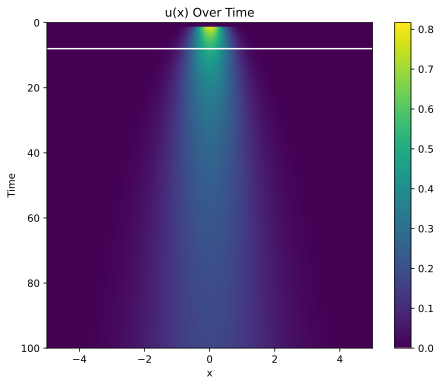

In [164]:
plt.imshow(np.abs(u_ANLY - u_RK4_2)/np.max(np.abs(u_ANLY)),aspect="0.1",extent=[-L/2,L/2,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.hlines(8,-5,5,"w")
plt.show()

In [74]:
np.max(np.abs(u_FE - u_RK4_2))/np.max(np.abs(u_FE))

0.029904749533318252

### Attempt 5: scipy.integrate.solve_ivp

Use an actual ODE library. If we don't specify method, I'm pretty sure it uses RK4. We should probably expect the best possible accuracy, given a differentiation method and spatiotemporal resolution from this integrator.

In [165]:
D_ivp = D_RK4
def deriv3(t,u):
    return D_ivp*np.real(np.fft.ifft(-(k_arr**2)*np.fft.fft(u)))

In [166]:
from scipy.integrate import solve_ivp

In [167]:
sol = solve_ivp(deriv3, [0, T_RK4], f_arr,
                t_eval=t_arr)

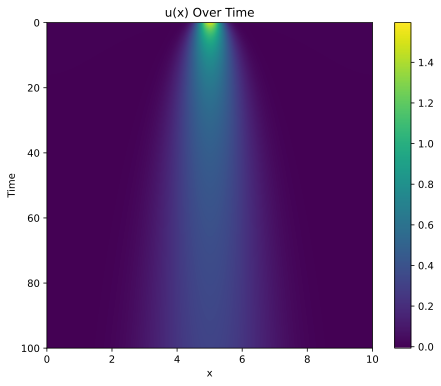

In [168]:
plt.imshow(sol.y.T,aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

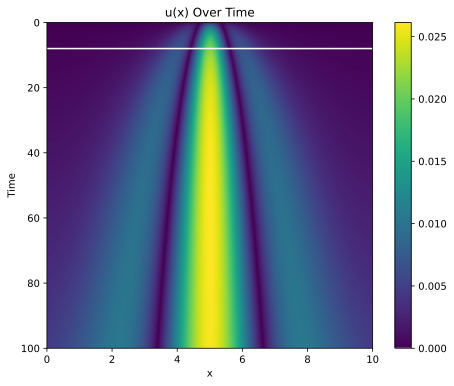

In [169]:
plt.imshow(np.abs(sol.y.T-u_ANLY)/np.max(np.abs(u_ANLY)),aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.hlines(8,0,L,"w")
plt.show()

In [72]:
sol.y.T.shape

(100000, 1000)

Seems that we need to make changes to the grid or the differentiator if we are going to get better than ~2.5% accuracy.

In [170]:
np.max(np.abs(sol.y.T[0:8000]-u_ANLY[0:8000]))/np.max(np.abs(u_ANLY[0:8000]))

0.020828187050182637

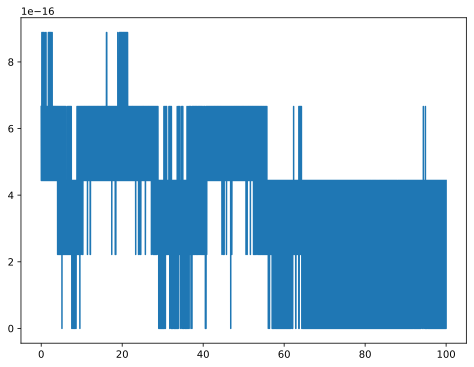

In [171]:
plt.plot(t_arr,[-1+(sol.y.T[j].sum())*dx for j in range(len(sol.y.T))])
plt.show()

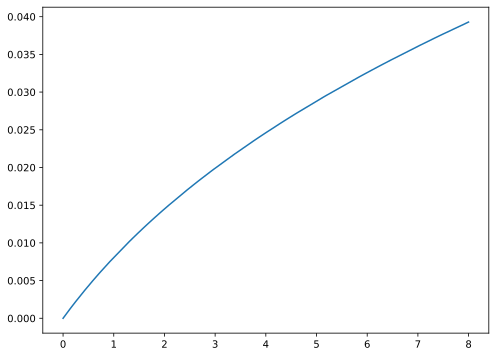

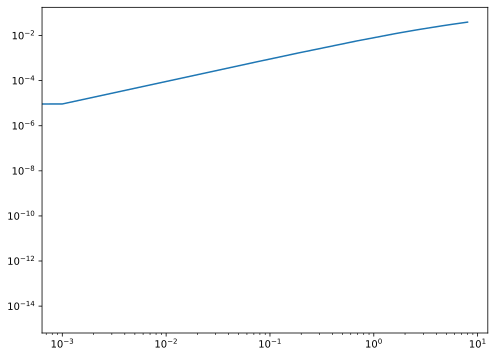

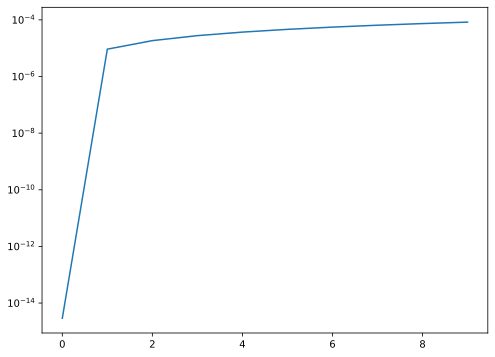

In [172]:
plt.plot([dt_RK4*t for t in range(8000)],np.array([np.max(np.abs(sol.y.T[t]-u_ANLY[t]))/np.max(np.abs(u_ANLY[t])) for t in range(8000)]))
plt.show()

plt.loglog([dt_RK4*t for t in range(8000)],np.array([np.max(np.abs(sol.y.T[t]-u_ANLY[t]))/np.max(np.abs(u_ANLY[t])) for t in range(8000)]))
plt.show()

plt.plot([t for t in range(10)],np.array([np.max(np.abs(sol.y.T[t]-u_ANLY[t]))/np.max(np.abs(u_ANLY[t])) for t in range(10)]))
plt.yscale("log")
plt.show()

Let's try to implement $4^\text{th}$ order Runge-Kutta while enforcing the BCs in the analytic solution above.

In [75]:
dt_RK4_BC = 0.001
T_RK4_BC = 100
s_RK4_BC = int(np.ceil(T_RK4_BC/dt_RK4_BC))
u_RK4_BC = np.zeros([s_RK4_BC,N])
D_RK4_BC = 0.01
# Need 4 initial values now
u_RK4_BC[0]=f_arr

We'll just do this super naively and set u_RK4_BC = 0 on the boundary at every timestep.

In [76]:
from tqdm import tqdm
for t in tqdm(range(0,s_RK4_BC-1)):
    #print("\r",end="")
    #print(f"Integrating PDE: {int(100*t/s_RK4_2)+1}%  ",end="",flush=True)
    f1 = deriv2(u_RK4_BC[t],D_RK4_BC)
    f2 = deriv2(u_RK4_BC[t] + (dt_RK4_BC/2)*f1,D_RK4_BC)
    f3 = deriv2(u_RK4_BC[t] + (dt_RK4_BC/2)*f2,D_RK4_BC)
    f4 = deriv2(u_RK4_BC[t] + dt_RK4_BC*f3,D_RK4_BC)
    u_RK4_BC[t+1] = u_RK4_BC[t] + (dt_RK4_BC/6)*(f1 + 2*f2 + 2*f3 + f4)
    u_RK4_BC[t+1, 0] = 0.0
    u_RK4_BC[t+1,-1] = 0.0

100%|████████████████████████████████████████████████████████| 99999/99999 [03:37<00:00, 459.36it/s]


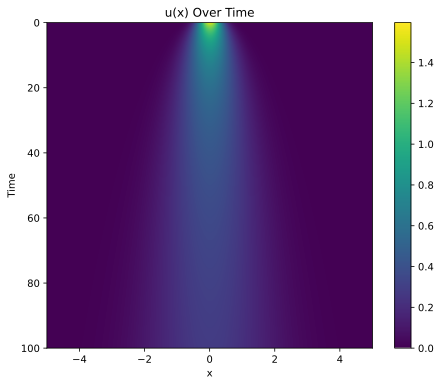

In [77]:
plt.imshow(np.real(u_RK4_BC),aspect="0.1",extent=[-L/2,L/2,T_RK,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

In [78]:
np.max(np.abs(u_ANLY - u_RK4_BC))/np.max(np.abs(u_ANLY))

0.1325141289496006

In [79]:
np.max(np.abs(sol.y.T - u_RK4_BC))/np.max(np.abs(sol.y.T))

0.11145988449111503

Whelp, thats not very good.

## Free-space solution to the diffusion equation.

Following Tong Kinetic theory page 6, I claim that the analytical solution for $$u(x,0) = \frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(x-L/2)^2}{2 \sigma^2}}$$

is given by $$u(x,t) = \frac{1}{\sqrt{2 \pi (2 D t + \sigma^2)}}e^{-\frac{(x-L/2)^2}{2 (2 D t + \sigma^2)}}.$$

Tong gives the solution for a delta-function initial condition which immediately evolves into a gaussian. I just redefine $t=0$ to be when Tong's gaussian looks like our initial condition.

I also claim that we should stop the time evolution when the free-space solution exceeds machine-epsilon at the boundaries. This can be found in mathematica: for $D = 0.01, \sigma = 0.25, L = 10$, we have $$t_{final} = 14.4072.$$

In [173]:
u_FS = np.array([(2*np.pi*(2*D_RK4*t + sig**2))**(-0.5)*np.exp(-((x_arr-L/2)**2.0)/(2*(2*D_RK4*t + sig**2))) for t in t_arr])

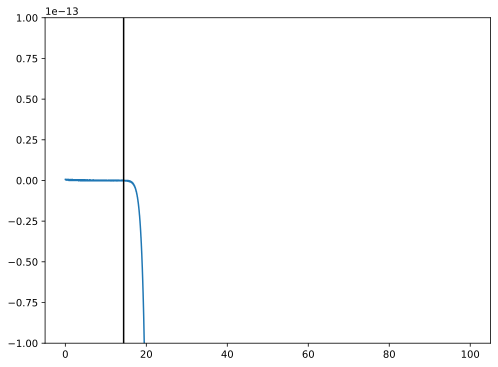

In [175]:
plt.plot(t_arr,[-1+(u_FS[j].sum())*dx for j in range(len(t_arr))])
plt.ylim([-10**(-13),10**(-13)])
plt.vlines(14.4,-0.01,0.001,"k")
plt.show()

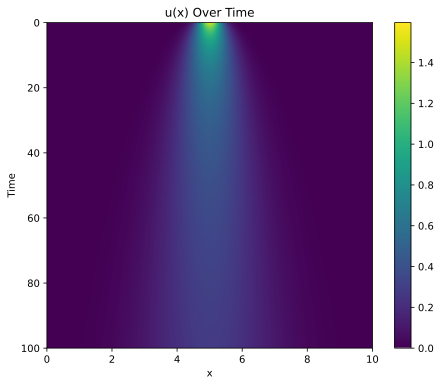

In [176]:
plt.imshow(u_FS,aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("u(x) Over Time")
plt.colorbar()
plt.show()

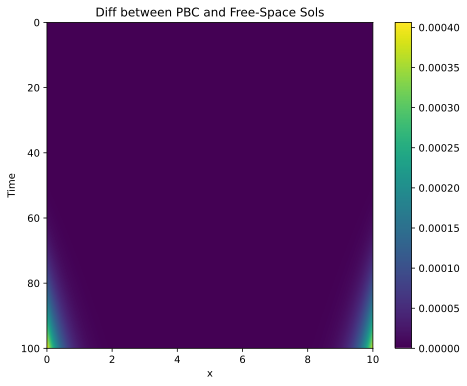

In [177]:
plt.imshow(np.abs(u_FS-u_ANLY)/np.max(np.abs(u_FS)),aspect="0.1",extent=[0,L,T_RK4,0])
plt.xlabel("x")
plt.ylabel("Time")
plt.title("Diff between PBC and Free-Space Sols")
plt.colorbar()
plt.show()

In [178]:
t_arr[14407]

14.407

In [179]:
times=t_arr[0:14408]

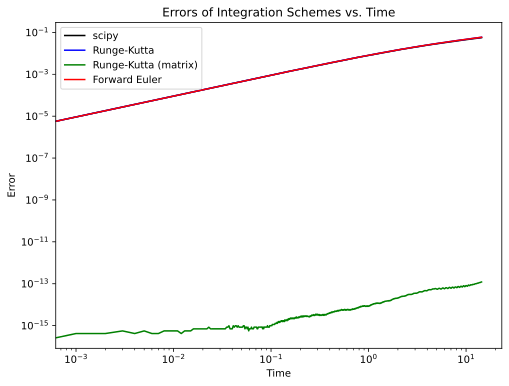

In [189]:
plt.loglog(times,np.array([np.max(np.abs(sol.y.T[t]-u_FS[t]))/np.max(np.abs(u_FS[t])) for t in range(14408)]),"k",label="scipy")
plt.loglog(times,np.array([np.max(np.abs(u_RK4[t]-u_FS[t]))/np.max(np.abs(u_FS[t])) for t in range(14408)]),"b",label="Runge-Kutta")
plt.loglog(times,np.array([np.max(np.abs(u_RK4_2[t]-u_FS[t]))/np.max(np.abs(u_FS[t])) for t in range(14408)]),"g",label="Runge-Kutta (matrix)")
plt.loglog(times,np.array([np.max(np.abs(u_FE[t]-u_FS[t]))/np.max(np.abs(u_FS[t])) for t in range(14408)]),"r",label="Forward Euler")
plt.ylabel("Error")
plt.xlabel("Time")
plt.title("Errors of Integration Schemes vs. Time")
plt.legend()
plt.show()

$\textbf{Double check this!!!!!!!}$. 

In [182]:
np.max(np.abs(u_FS[0:14408] - u_RK4[0:14408]))/np.max(u_FS[0:14408])

0.024846884802285328

In [188]:
np.max(np.abs(u_FS[0:14408] - u_RK4_2[0:14408]))/np.max(u_FS[0:14408])

5.1285035165472296e-14

In [183]:
np.max(np.abs(u_FS[0:14408] - u_FE[0:14408]))/np.max(u_FS[0:14408])

0.024839727251512962

In [184]:
np.max(np.abs(u_FS[0:14408] - sol.y.T[0:14408]))/np.max(u_FS[0:14408])

0.023647744265167647